RAINSTORM

## Seize labels

- This notebook will help us visualize the results from labeled videos of an experiment

#### Requirements:

- The position files (processed by ``2a-Prepare_positions``)
- The labels, geolabels or autolabels files (labeled by ``1-Behavioral_labeler``, ``2b-Geometric_analysis`` or ``3b-Automatic_analysis``)
- The movement files (processed by ``2b-Geometric_analysis``)

---
#### Load the necessary modules

In [1]:
import os
import rainstorm.seize_labels as rst

---
#### 1. State your project path and experiment details in the params file
Define the path to the same folder used in `2-Prepare_positions`, and the path to the parameters file.

Go to the params.yaml file and specify the parameters in the *seize_labels* section.

In [2]:
base = r'C:\Users\dhers\Desktop\Rainstorm'

folder_path = os.path.join(base, r'docs\examples\BSI')
params = os.path.join(folder_path, 'params.yaml')

---
#### 2. Visualize the behavioral labels on a video

The following function combines the position data, the behavioral labels, and the original video recording to create a video with the labels overlaid.

The video can be built both using the original video file or not... try removing the `video_path` argument from the function call to see the difference.

In [3]:
example_path = rst.choose_example_position(params, look_for = 'TS')
video_path = example_path.replace(r'TS\position', 'TS_videos').replace('_position.csv', '.mp4')

rst.create_video(params, example_path, video_path)

Example file: 2025_04-BSI-TS2-R09_C4d_position.csv
Could not open video file: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\TS2\position\2025_04-BSI-TS2-R09_C4d.mp4
Creating video...
Video created successfully: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\2025_04-BSI-TS2-R09_C4d_video.mp4


---
#### 3. Plot individual exploration


Exploration is a dynamic behavior, and experiment results can change a lot depending on the timeframe chosen for analysis. A first step to understanding the exploration dynamics is to plot the evolution of the cumulative exploration time.

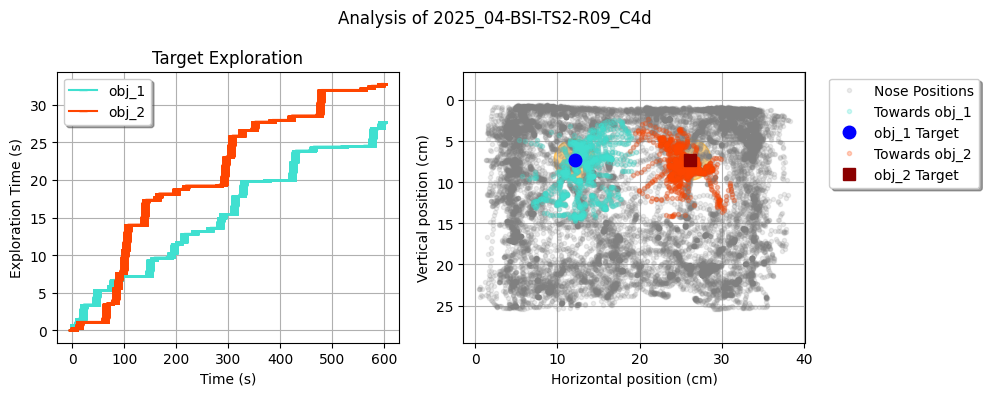

In [4]:
rst.plot_mouse_exploration(params, example_path)

This plot shows the behavior of a single subject, and does not take into account the role of each exploratory target. To build more elaborate plots, we need to inform the groups and target roles for each subject.

---
#### 4. Create a ‘reference.csv’ file on our experiment folder.
This function will use the groups, trials and target roles we state on the params file to create a ‘reference.csv’ file that will be used to organize the files and plot the experiment results.

In [5]:
reference_path = rst.create_reference_file(params)

CSV file 'C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\reference.csv' created successfully with the list of video files.


#### Go to the experiment folder and complete the 'reference.csv' file
If you are using the NOR example folder to try out rainstorm, you will find a copy of the ‘reference.csv’ file **already completed** in the experiment folder.

With the ‘reference.csv’ file complete, you can proceed to the next step where it will be used to create the 'summary' folder.

---
#### 5. Create the 'Summary' folder
This new folder will contain files for each video recording, which will be used to hold all the labels and geometric information.

The groups and objects on the ‘reference.csv’ file will be used to organize the files into subfolders, and the target columns will be renamed according to their role (e.g. Novel and Known).

In [6]:
summary_path = rst.create_summary(params)

Renamed and saved: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\summary\Veh\Hab\2025_04-BSI-Hab-R01_C2n_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\summary\BSI\Hab\2025_04-BSI-Hab-R02_C2i_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\summary\Veh\Hab\2025_04-BSI-Hab-R03_C2d_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\summary\BSI\Hab\2025_04-BSI-Hab-R04_C2a_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\summary\BSI\Hab\2025_04-BSI-Hab-R05_C3n_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\summary\Veh\Hab\2025_04-BSI-Hab-R06_C3i_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\summary\BSI\Hab\2025_04-BSI-Hab-R07_C3d_summary.csv
Renamed and saved: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\summary\BSI\Hab\2025_04-BSI-Hab-R08_C4i_summary.csv
Renamed and saved: C:\Us

---
#### 6. With our files ready, all is left to do is to run the analysis and plot the results.

We can plot:
- For any given trial:
    - plot_distance
    - plot_freezing
    - plot_freezing_boxplot
    - plot_freezing_histogram

- For trials involving target exploration:
    - plot_exploration_time
    - plot_exploration_boxplot

- For trials with **two** targets:
    - plot_DI
    - plot_exploration_scatterplot

- For trials involving time spent in areas:
    - plot_alternations
    - plot_roi_time (for Y Maze mostly)

Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\TR1_multiple_analyses.png


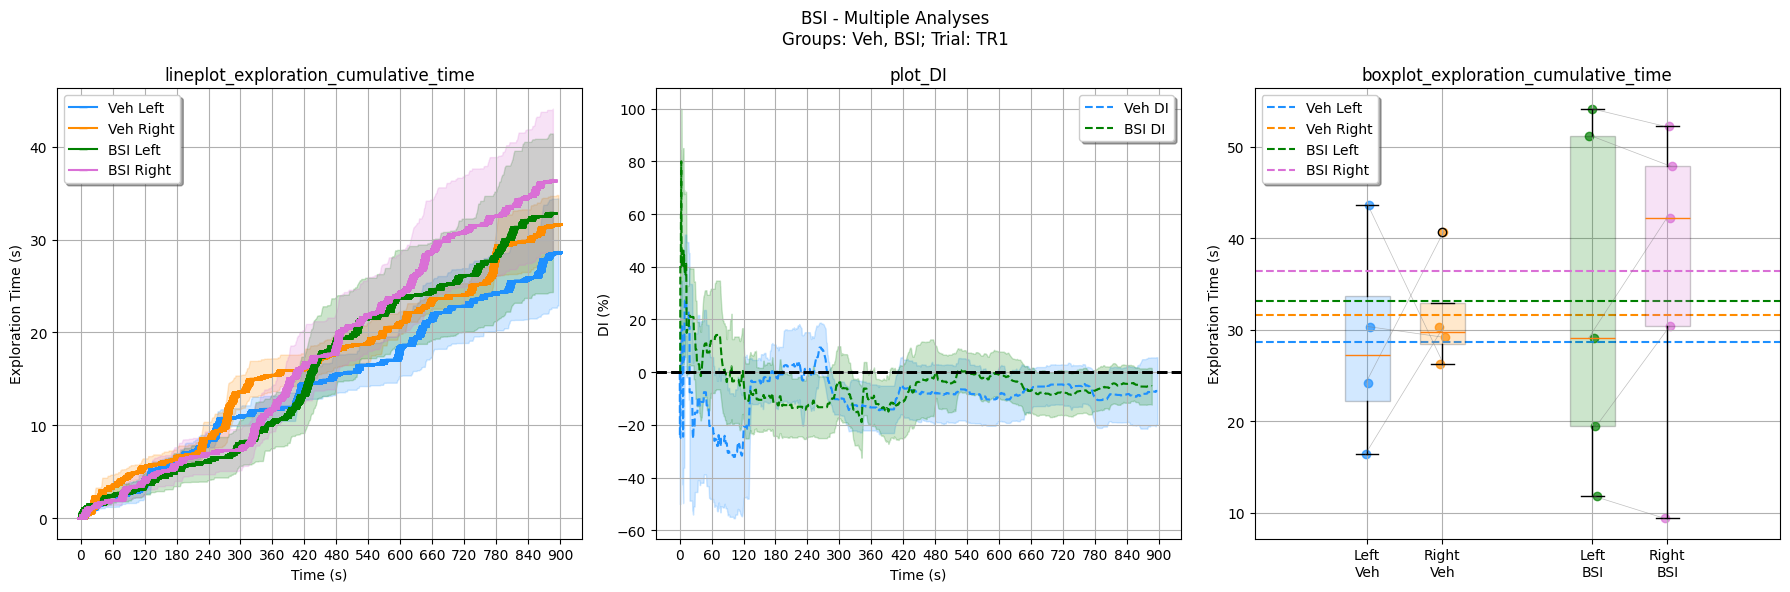

Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\TR2_multiple_analyses.png


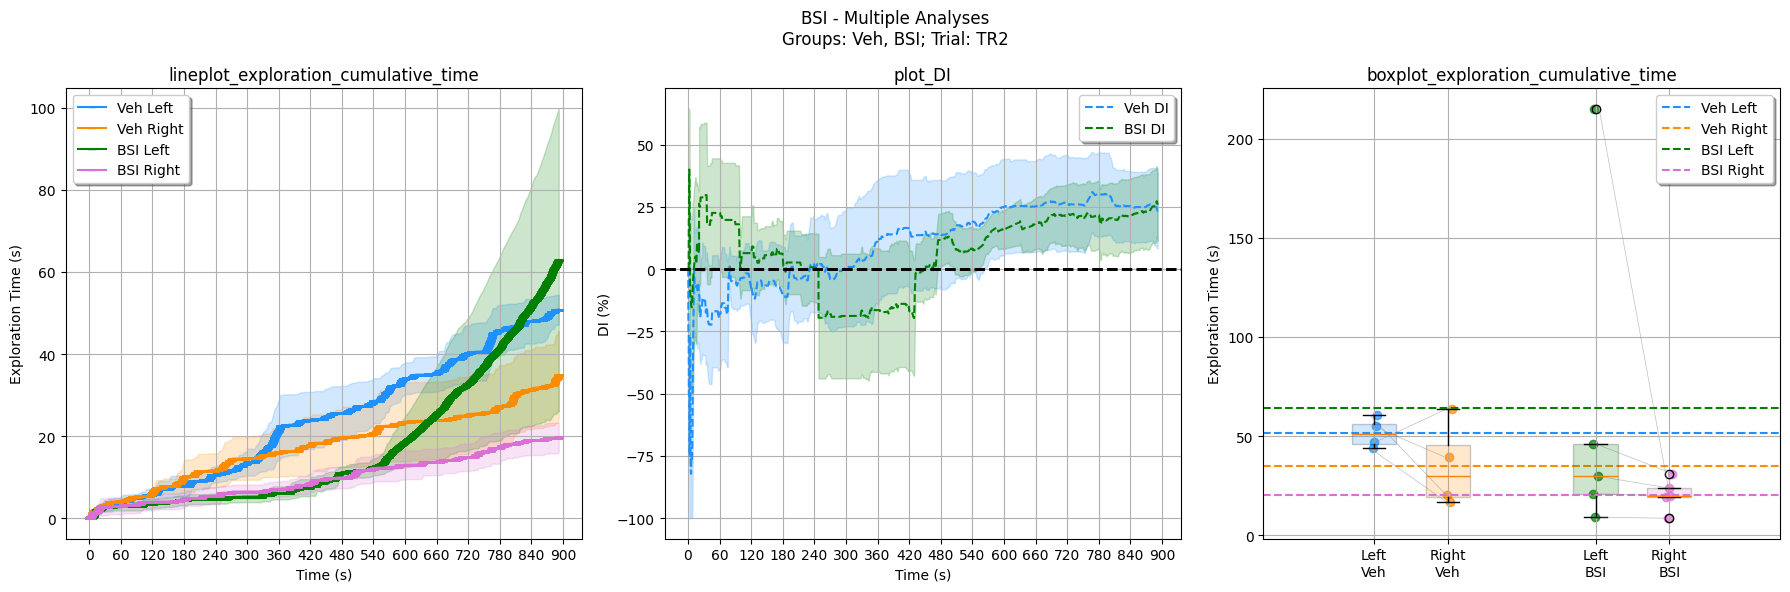

Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\TS1_multiple_analyses.png


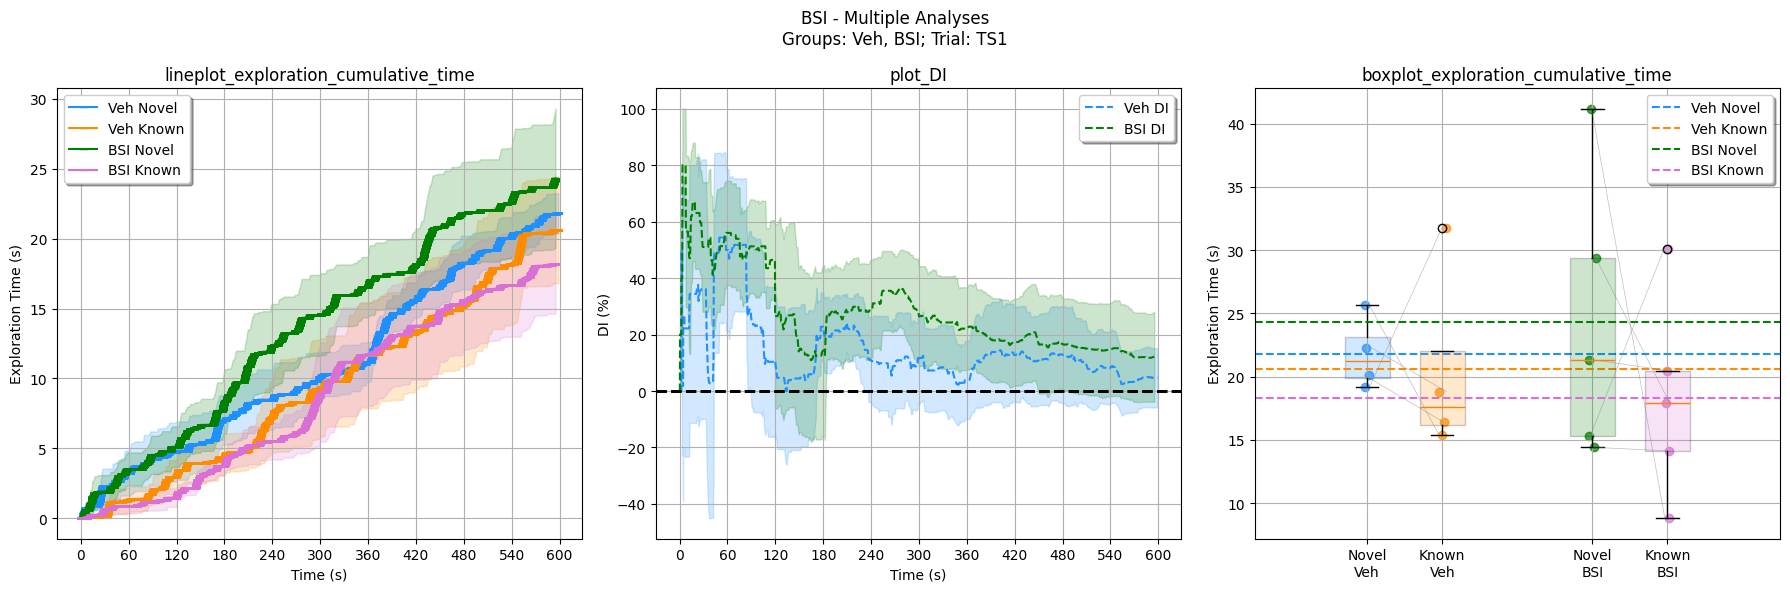

Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\TS2_multiple_analyses.png


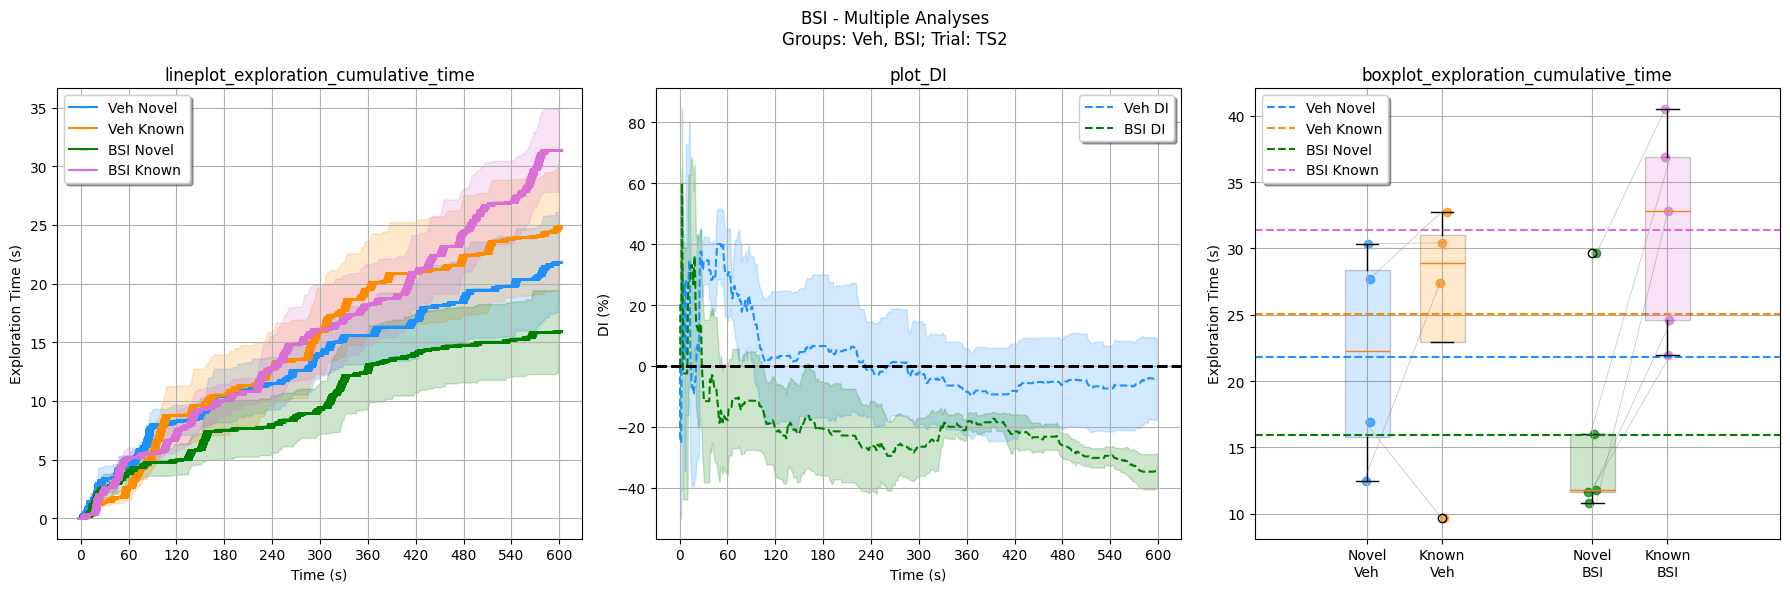

In [7]:
# rst.plot_multiple_analyses(params, trial='TR', plots=[rst.lineplot_exploration_cumulative_time, rst.plot_DI, rst.boxplot_exploration_cumulative_time])
rst.plot_multiple_analyses(params, trial='TR1', plots=[rst.lineplot_exploration_cumulative_time, rst.plot_DI, rst.boxplot_exploration_cumulative_time])
rst.plot_multiple_analyses(params, trial='TR2', plots=[rst.lineplot_exploration_cumulative_time, rst.plot_DI, rst.boxplot_exploration_cumulative_time])
rst.plot_multiple_analyses(params, trial='TS1', plots=[rst.lineplot_exploration_cumulative_time, rst.plot_DI, rst.boxplot_exploration_cumulative_time])
rst.plot_multiple_analyses(params, trial='TS2', plots=[rst.lineplot_exploration_cumulative_time, rst.plot_DI, rst.boxplot_exploration_cumulative_time])

---
#### 7. For each mouse, create individual plots

This function is thought particularly for experiments like Novel Object Recognition, since it only works properly if we have two targets on the arena.
The individual plots give us the chance to evaluate if something is off, and spot any behavioral outliers on both training and testing sessions.

You can test it with the demo data without problems, the plots will be stored in the example folder.

In [8]:
rst.plot_all_individual_exploration(params)

No data for target novelty found for trial Hab. Skipping.
Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\individual\2025_04-BSI-TR1-R01_C2n.png
Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\individual\2025_04-BSI-TR1-R03_C2d.png
Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\individual\2025_04-BSI-TR1-R06_C3i.png
Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\individual\2025_04-BSI-TR1-R09_C4d.png
Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\individual\2025_04-BSI-TR2-R01_C2n.png
Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\individual\2025_04-BSI-TR2-R03_C2d.png
Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\individual\2025_04-BSI-TR2-R06_C3i.png
Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\plots\individual\2025_04-BSI-TR2-R09_C4d.png
Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\e

---
---
#### These modular graphs are intended to show the dynamic behavior of mice, providing a deeper insight into what happens during learning and memory.

We have reached the end of this project. If you have read and followed the code up to this point, I want to thank you for your time and attention.

If you have any questions and/or suggestions, do not hesitate to write: sdhers@fbmc.fcen.uba.ar


---
RAINSTORM - Created on Jun 25, 2024 - @author: Santiago D'hers

In [9]:
rst.create_results_file(params)

Results file saved at C:\Users\dhers\Desktop\Rainstorm\docs\examples\BSI\results.csv


'C:\\Users\\dhers\\Desktop\\Rainstorm\\docs\\examples\\BSI\\results.csv'

Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\PD\plots\TS_multiple_analyses_1.png


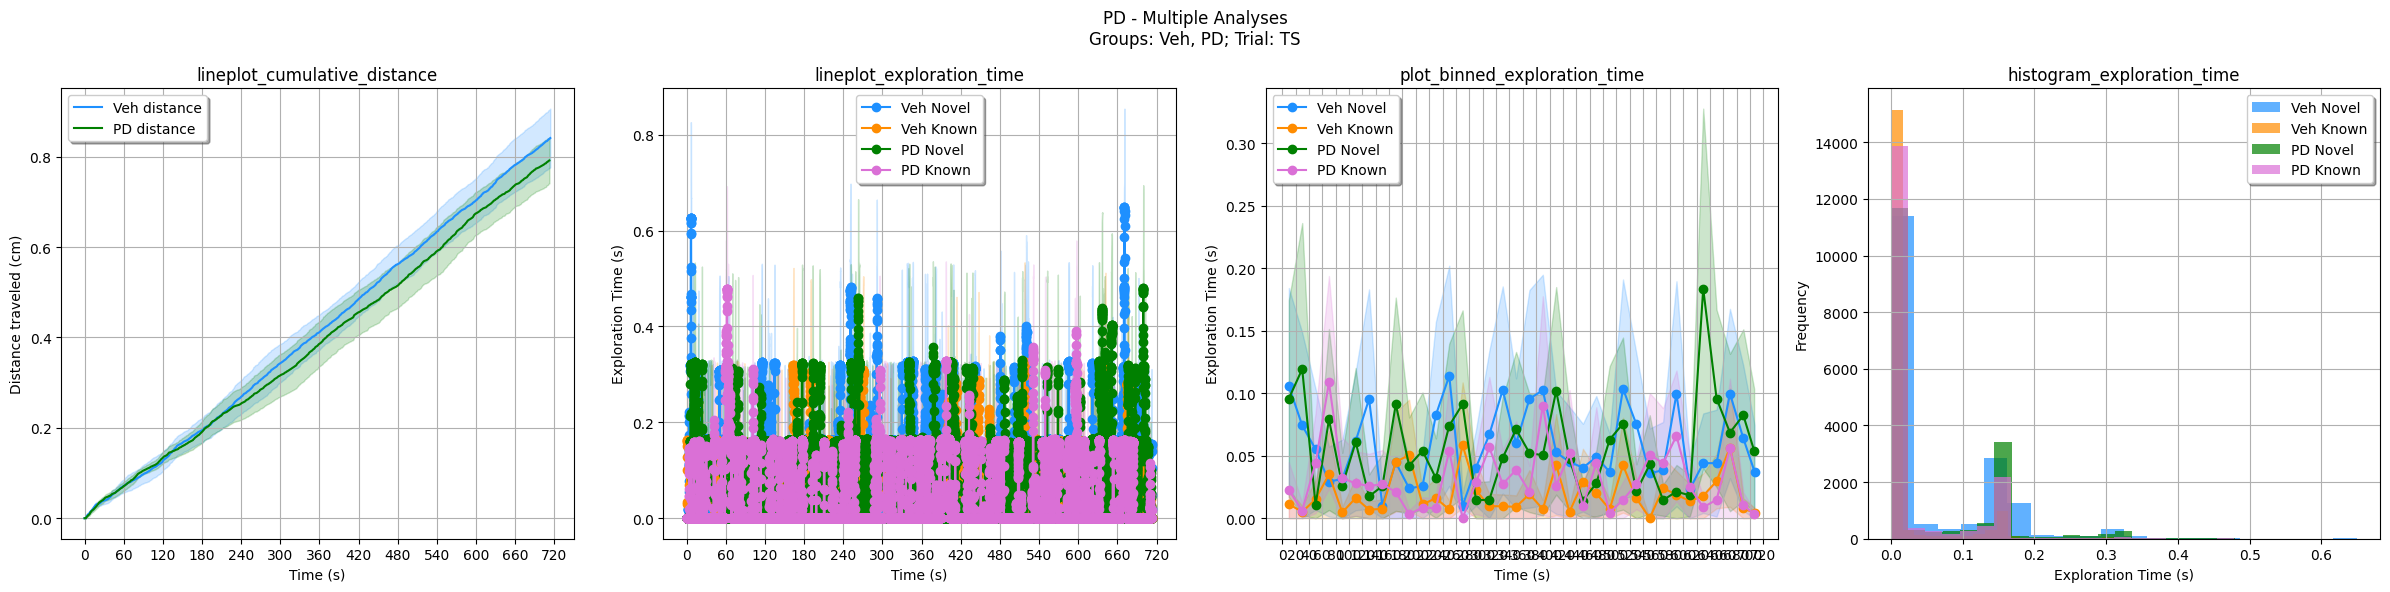

Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\PD\plots\TS_multiple_analyses_2.png


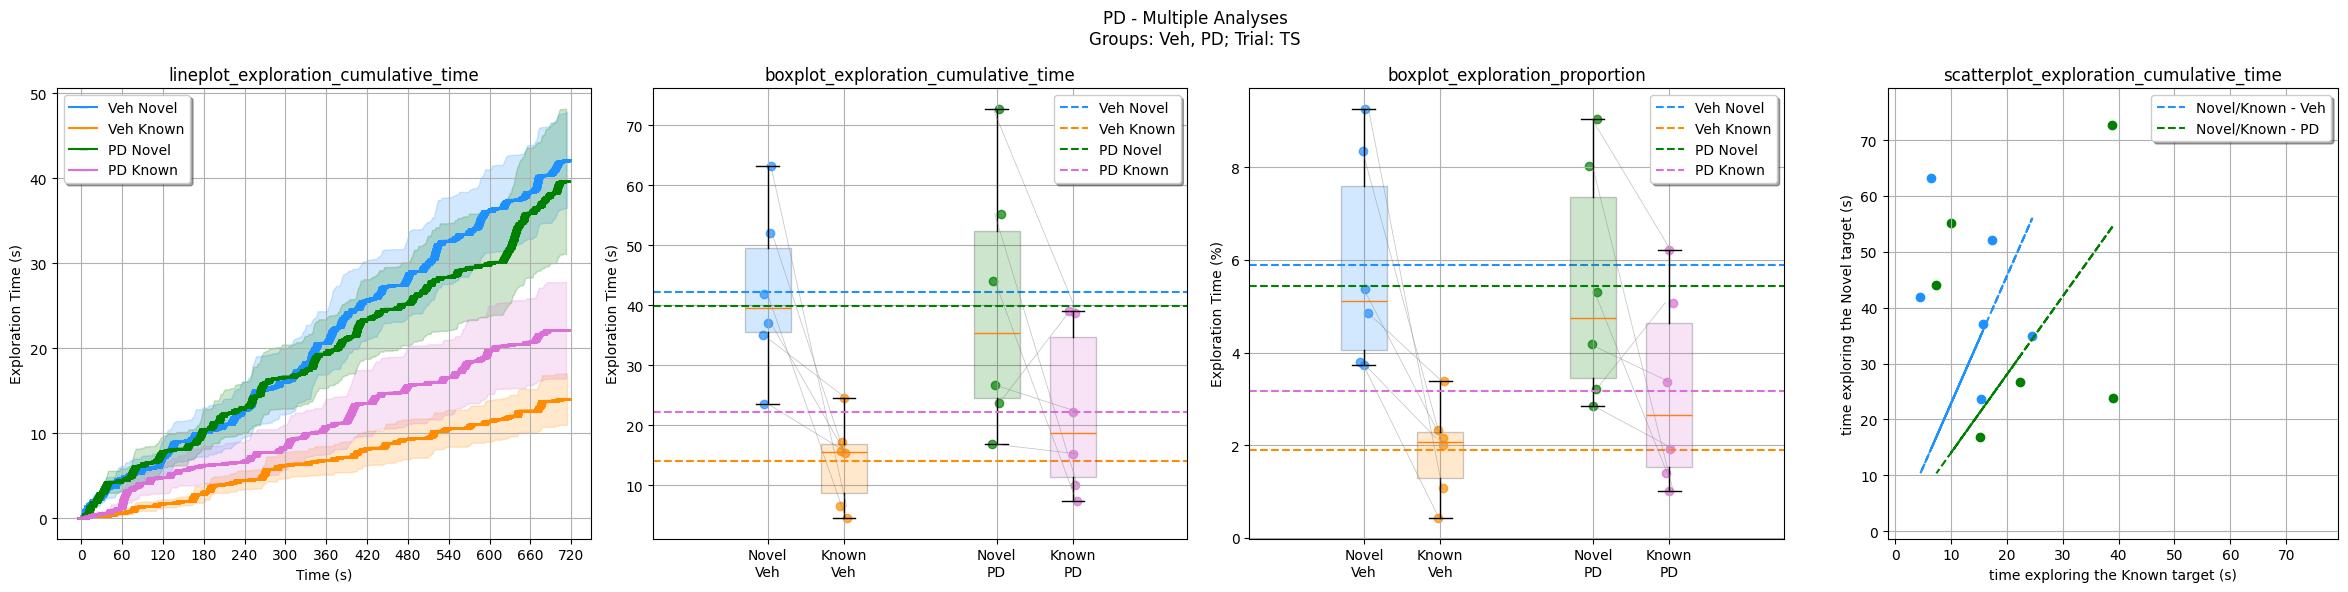

Plot saved at: C:\Users\dhers\Desktop\Rainstorm\docs\examples\PD\plots\TS_multiple_analyses_3.png


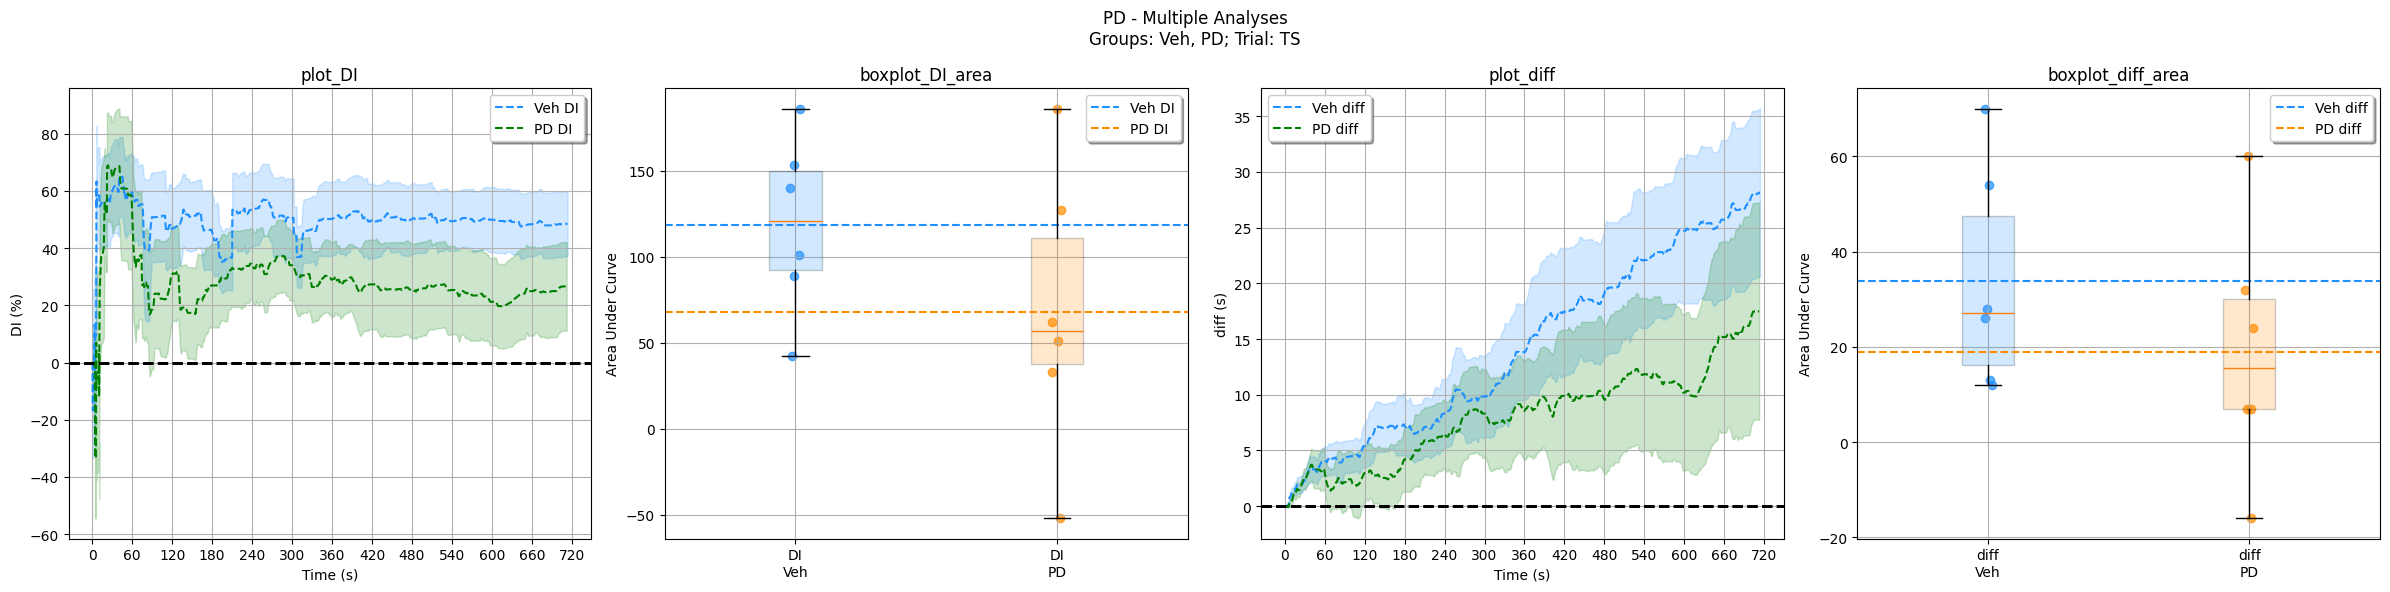

In [10]:
# Try out other plots
rst.plot_multiple_analyses(params, trial='TS', plots=[rst.lineplot_cumulative_distance, rst.lineplot_exploration_time, rst.plot_binned_exploration_time, rst.histogram_exploration_time])
rst.plot_multiple_analyses(params, trial='TS', plots=[rst.lineplot_exploration_cumulative_time, rst.boxplot_exploration_cumulative_time, rst.boxplot_exploration_proportion, rst.scatterplot_exploration_cumulative_time])
rst.plot_multiple_analyses(params, trial='TS', plots=[rst.plot_DI, rst.boxplot_DI_area, rst.plot_diff, rst.boxplot_diff_area])